# Deep Learning: Transfer Learning with ResNet18

## 🎯 Objective
Why train a massive model from scratch when we can stand on the shoulders of giants? In this notebook, we utilize **Transfer Learning** with a pre-trained **ResNet18** model. Instead of training millions of parameters to recognize edges and textures from zero, we leverage a model already trained on ImageNet and adapt it to classify images from the **STL-10** dataset.

## 📚 Key Concepts
* **ResNet18:** A powerful 18-layer Convolutional Neural Network that uses "residual connections" to train deep networks effectively.
* **ImageNet Normalization:** Pre-trained models expect input images to be pre-processed in the exact same way they were trained (specific size, mean, and standard deviation).
* **Freezing Weights:** The process of disabling gradient updates for early layers to preserve their learned feature extractors.
* **Replacing the Head:** Swapping the final classification layer (originally 1000 classes for ImageNet) with a new layer matching our specific task (10 classes for STL-10).

## 1. Import Libraries

We import the necessary PyTorch libraries. Note that we rely heavily on `torchvision` for accessing the ResNet model architecture and the pre-trained weights.

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 2. Data Preparation: The ResNet Standard

Pre-trained models are picky. ResNet18 was trained on ImageNet images that were:
1.  Resized to **224x224** pixels.
2.  Normalized with specific mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]`.

We **must** apply these exact transformations to our STL-10 data, or the pre-trained weights will interpret the pixel values incorrectly.

In [3]:
### Note: resnet is trained for images in a specific range (NOT [-1,1]).
#         That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                       T.Resize((224, 224)),
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

100%|██████████| 2.64G/2.64G [00:22<00:00, 115MB/s] 


## 3. Data Inspection

Let's check the data. Because of the aggressive normalization (subtracting mean, dividing by std), the pixel values will no longer be in the standard [0, 1] range. They will include negative numbers and values greater than 1.

In [4]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(np.uint8(0), np.uint8(255))

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [ ]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 224x224 for resnet.
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 224, 224])

Data value range:
(tensor(-2.1179), tensor(2.6400))


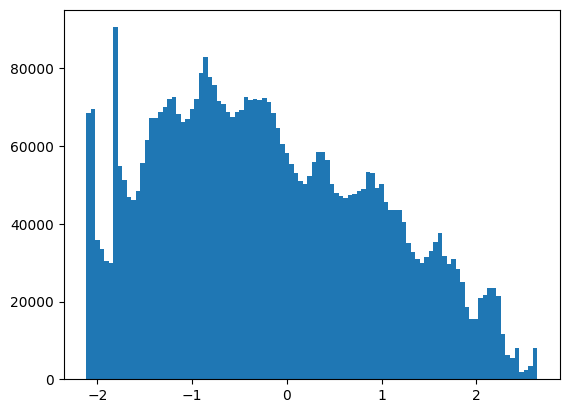

In [6]:
# histogram of the data
plt.hist(X.data.numpy().flatten(),100);

### Visualizing Normalized Images
To view these images with `matplotlib`, we need to undo the normalization. If we plot the raw tensor, it will look distorted (weird colors) because `imshow` expects RGB values in specific ranges.

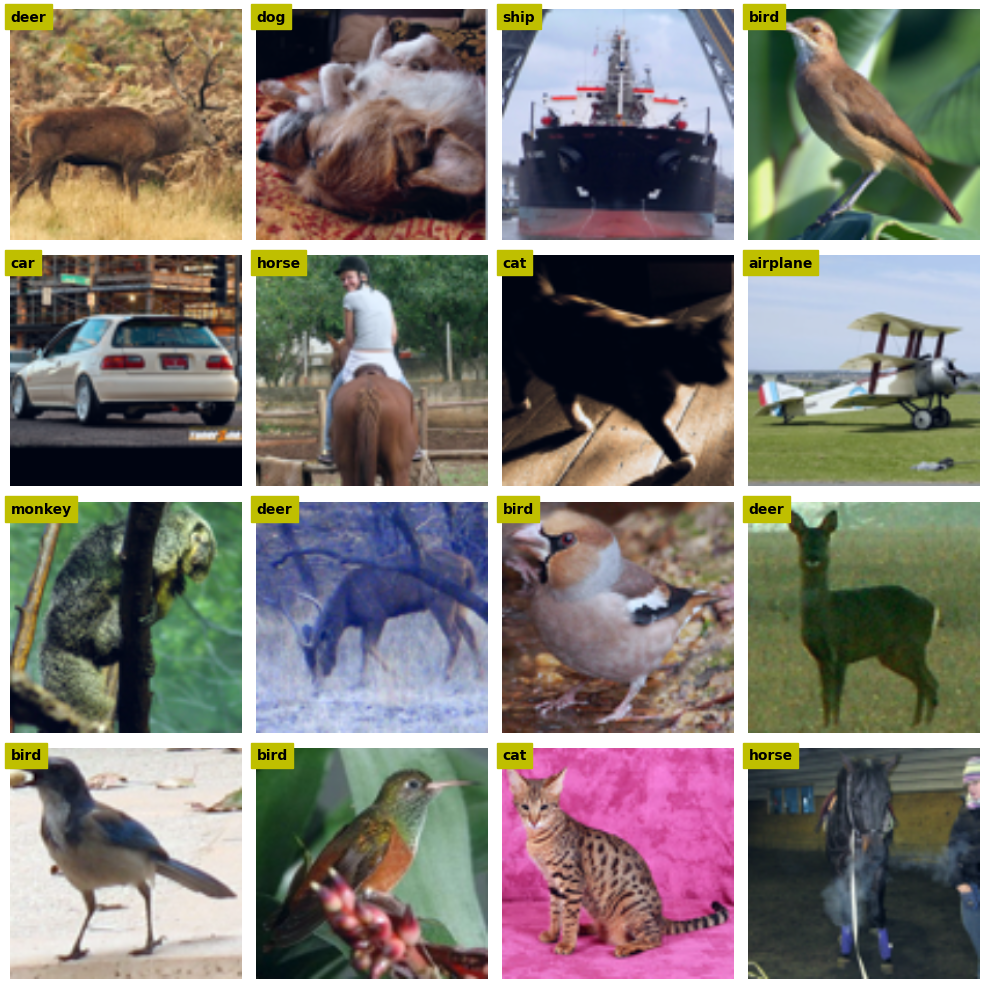

In [7]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Importing the Pre-trained Model

We load ResNet18 with default weights (trained on ImageNet). 
* **`ResNet18_Weights.DEFAULT`**: Downloads the best available weights.
* **`summary`**: We inspect the architecture.

In [8]:
# The following line was recorded in the video, but is now depreciated. See also Q&A.
# resnet = torchvision.models.resnet18(pretrained=True)

# You can use the following instead.
weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet = torchvision.models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


In [9]:
# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
from torchsummary import summary
summary(resnet.to(device),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 5. Freezing and Replacing Layers

This is the Transfer Learning step.
1.  **Freeze:** We loop through all parameters and set `p.requires_grad = False`. This ensures that backpropagation will **not** update the convolutional weights. We trust that ResNet already knows how to detect lines, curves, and textures.
2.  **Replace Head:** We overwrite `resnet.fc` (the fully connected layer at the end). The new layer (`Linear(512, 10)`) is created from scratch, so its `requires_grad` is `True` by default. This is the only part of the network we will train.

In [12]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False

    # python note: the above operation can be implemented in-line:
    #p.requires_grad_(False)

In [13]:
# change the final layer
resnet.fc = nn.Linear(512,10)

In [14]:
# push the model to the GPU (if using)
resnet.to(device);

## 6. Training the Model

We train the network using Stochastic Gradient Descent. Because only the final layer has gradients enabled, the optimizer will only update the weights of the classifier head. The vast majority of the network (the feature extractors) remains static.

In [15]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(),lr=0.001,momentum=.9)

In [16]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 92.42%
Finished epoch 2/10. Test accuracy = 93.62%
Finished epoch 3/10. Test accuracy = 94.19%
Finished epoch 4/10. Test accuracy = 94.09%
Finished epoch 5/10. Test accuracy = 94.18%
Finished epoch 6/10. Test accuracy = 94.37%
Finished epoch 7/10. Test accuracy = 94.64%
Finished epoch 8/10. Test accuracy = 94.48%
Finished epoch 9/10. Test accuracy = 94.89%
Finished epoch 10/10. Test accuracy = 94.75%


## 7. Performance Visualization

We plot the loss and accuracy. We expect relatively high accuracy very quickly because the network already knows how to process images effectively.

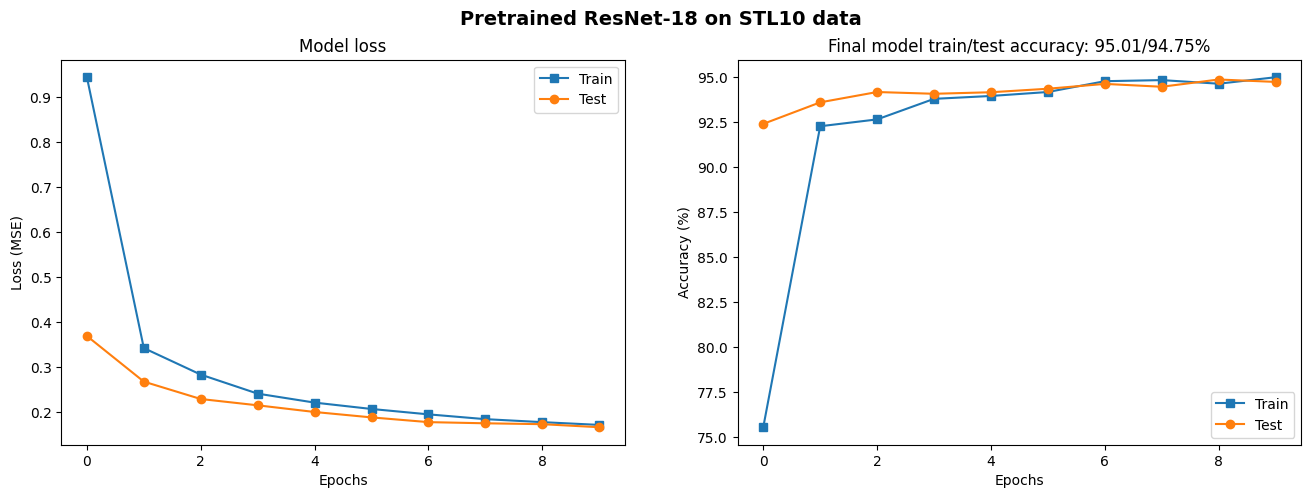

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

## 8. Visualizing Predictions

Finally, we visualize the model's predictions on test images. We use green labels for correct predictions and red for incorrect ones to easily spot errors.

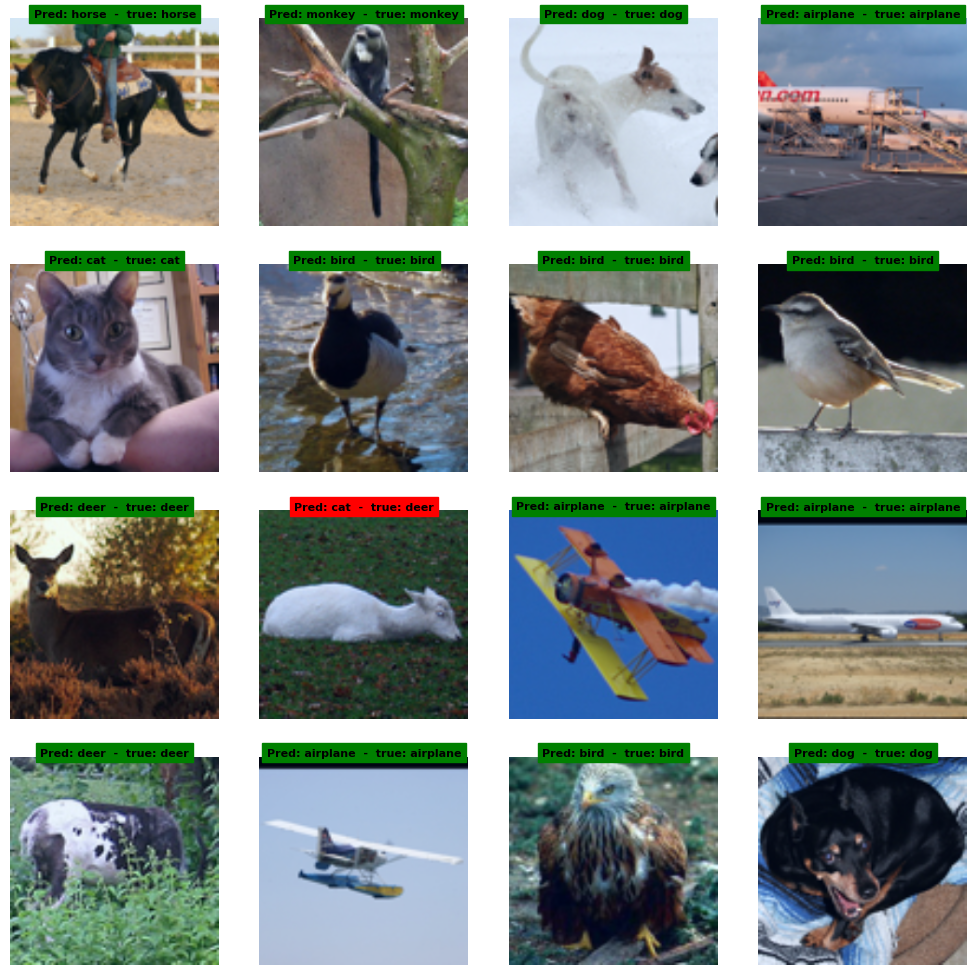

In [18]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # show the image
  ax.imshow(pic)


  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'
  #ax.set_title(title)
  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(112,-10,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()